In [1]:
import setGPU

setGPU: Setting GPU to: 0


# Generate data

In [2]:
random_state = 999

n_classes = 3
n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

In [3]:
# experiment parameters
n_classes = 3
n_features = 2
n_samples_tr = 4000  # number of training set samples
n_samples_ts = 1000  # number of testing set samples
batch_size = 20

# dataset creation
from secml.data.loader import CDLRandom
dataset = CDLRandom(n_samples=n_samples_tr + n_samples_ts,
                    n_classes=n_classes,
                    n_features=n_features, n_redundant=0,
                    n_clusters_per_class=1,
                    class_sep=1, random_state=0).load()

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(train_size=n_samples_tr,
                           test_size=n_samples_ts,
                           random_state=0)

tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features.normalization import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

/home/crecchi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


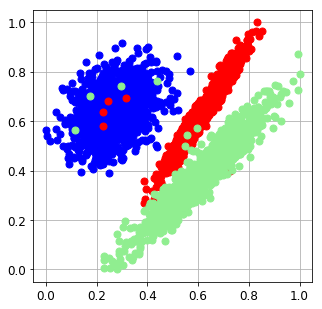

In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=5, height=5)

# Convenience function for plotting a dataset
fig.sp.plot_ds(tr)

fig.show()

# Classifying blobs

In [5]:
import torch
from torch import nn

class Net(nn.Module):
    """
    Model with input size (-1, 5) for blobs dataset
    with 5 features
    """
    def __init__(self, n_features, n_classes):
        """Example network."""
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Random seed
torch.manual_seed(0)

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes)

from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
from secml.ml.classifiers import CClassifierPyTorch
dnn = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=0)

In [7]:
# clf.verbose = 1  # Can be used to display training process output
print("Training started...")
dnn.fit(tr)
print("Training completed!")

Training started...
Training completed!


In [8]:
label_torch = dnn.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
acc_torch = CMetric.create('accuracy').performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.991


# Generate Adversarial Samples

In [9]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=dnn,
                                    surrogate_classifier=dnn,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [10]:
from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=dnn.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 98.00%
Accuracy on reduced test set after attack: 0.00%


## Visualize evasion

In [ ]:
attack = pgd_ls_attack

In [ ]:
dmax = attack.dmax
dmax

In [ ]:
x0 = attack_ds.X[-1, :]
x0

In [ ]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=dmax)

fig = CFigure(width=16, height=6, markersize=12)
fig.subplot()

# Convenience function for plotting the attack objective function
fig.sp.plot_fun(attack.objective_function, plot_levels=False,
                multipoint=True, n_grid_points=200)
# Let's also plot the decision boundaries of the classifier
fig.sp.plot_decision_regions(dnn, plot_background=False, n_grid_points=200)

# Construct an array with the original point and the adversarial example
# adv_path = x0.append(adv_ds.X, axis=0)

# Convenience function for plotting the optimization sequence
fig.sp.plot_path(attack.x_seq)

# Convenience function for plotting a constraint
fig.sp.plot_constraint(constraint)

fig.sp.title(attack.class_type)
fig.sp.grid(grid_on=False)
fig.show()

We can see that the initial point x0 (red hexagon) has been perturbed in the feature space so that is actually classified by the SVM as a point from another class. The final adversarial example is the green star. We also show the l2 constraint as a black circle which has limited the maximum perturbation applicable to x0.

# Security evaluation of a classifier

Running security evaluation...


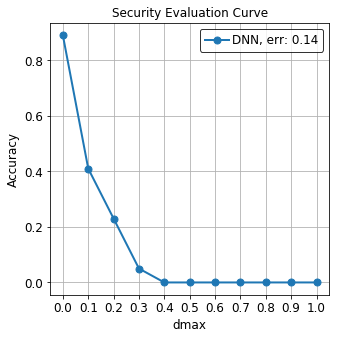

In [40]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
dnn_sec_eval = CSecEval(attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
dnn_sec_eval.run_sec_eval(attack_ds, double_init=False)

from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    dnn_sec_eval.sec_eval_data, marker='o', label='DNN', show_average=True)

In [51]:
dnn_sec_eval.sec_eval_data

CSecEvalData{'param_name': 'dmax', 'param_values': CArray(11,)(dense: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]), 'scores': [CArray(100, 4)(dense: [[-1.021364 -1.001276  1.014083  1.      ] [ 1.048215 -1.019683 -1.027884  1.      ] [-1.18296   1.18801  -1.019838  1.      ] ... [-0.999891 -1.000201  1.000044  1.      ] [ 1.000377 -1.000253 -1.00028   1.      ] [-1.039259  1.009565 -1.020076  1.      ]]), CArray(100, 4)(dense: [[-1.033945  0.238134 -0.120123  1.      ] [ 1.03649  -1.025869 -1.017105  1.      ] [ 0.691159 -0.744797 -0.990558  1.      ] ... [-1.003435 -0.175481  0.236     1.      ] [ 1.00418  -1.004734 -0.999653  1.      ] [-1.00058  -1.4052    1.297247  1.      ]]), CArray(100, 4)(dense: [[-0.935577  0.934161 -1.023782  1.      ] [ 0.969044 -0.956849 -1.01297   1.      ] [ 1.00052  -1.005892 -1.000121  1.      ] ... [-0.486917  0.462823 -0.996646  1.      ] [ 0.890351 -0.984563 -1.005698  1.      ] [-1.000196 -0.999944  1.000275  1.      ]]), CArray(100, 4)(dense: [[ 

---

# Get DNN features

In [12]:
from secml.ml.features import CNormalizerDNN

In [13]:
feat_extr = CNormalizerDNN(dnn)
feat_extr

CNormalizerDNN{'net': CClassifierPyTorch{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 2, 'preprocess': None, 'model': Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
), 'trained': True, 'input_shape': (2,), 'softmax_outputs': False, 'batch_size': 1, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'optimizer_scheduler': None, 'epochs': 10}, 'out_layer': None, 'preprocess': None}

In [14]:
feats_tr = feat_extr.forward(tr.X)
feats_ts = feat_extr.forward(ts.X)
feats_tr.shape, feats_ts.shape

((4000, 3), (1000, 3))

# Train an SVM-RBF ontop

In [15]:
from secml.data.c_dataset import CDataset

In [16]:
feat_tr_ds = CDataset(feats_tr, tr.Y)
feat_ts_ds = CDataset(feats_ts, ts.Y)

In [17]:
# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
feat_tr_ds.X = nmz.fit_transform(feat_tr_ds.X)
feat_ts_ds.X = nmz.transform(feat_ts_ds.X)

In [18]:
# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.kernels import CKernelRBF
clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

In [19]:
# # Parameters for the Cross-Validation procedure
# xval_params = {'C': [1e-2, 0.1, 1], 'kernel.gamma': [10, 100, 1e3]}

# # Let's create a 3-Fold data splitter
# from secml.data.splitter import CDataSplitterKFold
# xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# # Select and set the best training parameters for the classifier

# # clf.verbose = 1

# print("Estimating the best training parameters...")
# best_params = clf.estimate_parameters(
#     dataset=feat_tr_ds,
#     parameters=xval_params,
#     splitter=xval_splitter,
#     metric='accuracy',
#     perf_evaluator='xval'
# )

# print("The best training parameters are: ",
#       [(k, best_params[k]) for k in sorted(best_params)])

In [20]:
clf.classifier.C = 1
clf.classifier.kernel = CKernelRBF(gamma=100)

In [21]:
# We can now fit the classifier
clf.fit(feat_tr_ds)

# Compute predictions on a test set
y_pred = clf.predict(feat_ts_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=feat_ts_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 99.10%


---

# Wrap it with reject

In [22]:
from secml.ml.classifiers.reject import CClassifierRejectThreshold

clf_rej = CClassifierRejectThreshold(clf, 0.)
clf_rej.threshold

0.0

Set the `threshold` to have around 10% of false positives

In [23]:
clf_rej.threshold = 1.0

In [24]:
# Compute predictions on a test set
y_pred = clf_rej.predict(feat_tr_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=feat_tr_ds.Y, y_pred=y_pred)

print("Accuracy on training set: {:.2%}".format(acc))

Accuracy on training set: 89.12%


In [25]:
fpr = (y_pred < 0).sum() / y_pred.shape[0]
fpr

0.10325

In [26]:
# Compute predictions on a test set
y_pred = clf_rej.predict(feat_ts_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=feat_ts_ds.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 89.50%


# Test it against BB adversarial samples

In [27]:
adv_feats = nmz.transform(feat_extr.forward(eva_adv_ds.X))
adv_feats.shape

(100, 3)

In [28]:
adv_feats[:10,:].tondarray()

array([[ 1.25791617e+00,  1.23389908e+00, -3.16522016e-01],
       [-3.98903375e-03,  5.17891561e-01,  1.00406421e+00],
       [ 1.25791617e+00,  1.23389908e+00, -3.16522016e-01],
       [ 1.25791617e+00,  1.23389908e+00, -3.16522016e-01],
       [ 1.25791617e+00,  1.23389908e+00, -3.16522016e-01],
       [ 0.00000000e+00,  5.25794974e-01,  9.98478938e-01],
       [ 0.00000000e+00,  5.25794974e-01,  9.98478938e-01],
       [ 1.13559730e-03,  5.09394782e-01,  1.00155381e+00],
       [ 0.00000000e+00,  5.25794974e-01,  9.98478938e-01],
       [ 0.00000000e+00,  5.25794974e-01,  9.98478938e-01]])

In [29]:
foo = clf_rej.forward(adv_feats)
foo.tondarray()[:30]

array([[ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [-0.96885434, -0.98933067,  0.94417401,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [-0.99452561, -0.99855287,  0.98302664,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [ 0.04489459, -0.62017878, -0.45863329,  1.        ],
       [-1.0003935 , -1.00031053,  0.97945123,  1.        ],
       [ 0.04489459, -0.

In [30]:
import numpy as np
from secml.array import CArray

Y_adv = CArray(np.ones(eva_adv_ds.Y.shape[0]) * -1)
Y_adv

CArray(100,)(dense: [-1. -1. -1. ... -1. -1. -1.])

In [31]:
# Compute predictions on a test set
y_pred = clf_rej.predict(adv_feats)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=Y_adv, y_pred=y_pred)

print("Accuracy on adversarial samples: {:.2%}".format(acc))

Accuracy on adversarial samples: 100.00%


---

# White-box evaluation

Combining NN + SVM in a unique classifier

In [32]:
nmz.preprocess = feat_extr
clf_rej.preprocess = nmz

In [33]:
clf_rej

CClassifierRejectThreshold{'clf': CClassifierMulticlassOVA{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 3, 'preprocess': None}, 'threshold': 1.0, 'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 3, 'preprocess': CNormalizerMinMax{'feature_range': (0.0, 1.0), 'min': CArray(3,)(dense: [-11.802628  -1.174436 -24.861677]), 'max': CArray(3,)(dense: [19.891415  6.544275  7.932477]), 'm': CArray(3,)(dense: [0.031552 0.129555 0.030493]), 'q': CArray(3,)(dense: [0.372393 0.152154 0.758113]), 'preprocess': CNormalizerDNN{'net': CClassifierPyTorch{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 2, 'preprocess': None, 'model': Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
), 'trained': True, 'input_shape': (2,), 'softmax_outputs': False, 'batch_size': 1, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [34]:
clf_rej.forward(eva_adv_ds.X)

CArray(100, 4)(dense: [[ 0.044895 -0.620179 -0.458633  1.      ] [-0.968854 -0.989331  0.944174  1.      ] [ 0.044895 -0.620179 -0.458633  1.      ] ... [ 0.044895 -0.620179 -0.458633  1.      ] [-1.000393 -1.000311  0.979451  1.      ] [ 0.044895 -0.620179 -0.458633  1.      ]])

In [35]:
clf_rej.forward(eva_adv_ds.X) == foo

CArray(100, 4)(dense: [[ True  True  True  True] [ True  True  True  True] [ True  True  True  True] ... [ True  True  True  True] [ True  True  True  True] [ True  True  True  True]])

Whitebox attack

In [63]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:100, :]
surrogate_ds = tr

# attack_ds = CDataset(nmz.transform(ts[:100, :].X), ts.Y[:100])
# surrogate_ds = CDataset(nmz.transform(tr.X), tr.Y)

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf_rej,
                                    surrogate_classifier=dnn, #clf_rej,
                                    surrogate_data=surrogate_ds,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [37]:
import numpy as np
from secml.array import CArray

Y_adv = CArray(np.ones(eva_adv_ds.Y.shape[0]) * -1)
Y_adv

CArray(100,)(dense: [-1. -1. -1. ... -1. -1. -1.])

In [38]:
# Compute predictions on a test set
y_pred = clf_rej.predict(eva_adv_ds.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=Y_adv, y_pred=y_pred)

print("Accuracy on adversarial samples: {:.2%}".format(acc))

Accuracy on adversarial samples: 100.00%


In [39]:
clf_rej.predict(eva_adv_ds.X, return_decision_function=True)

(CArray(100,)(dense: [-1 -1 -1 ... -1 -1 -1]),
 CArray(100, 4)(dense: [[ 0.044895 -0.620179 -0.458633  1.      ] [-0.968854 -0.989331  0.944174  1.      ] [ 0.044895 -0.620179 -0.458633  1.      ] ... [ 0.044895 -0.620179 -0.458633  1.      ] [-1.000393 -1.000311  0.979451  1.      ] [ 0.044895 -0.620179 -0.458633  1.      ]]))

# WB Detector Security Evaluation

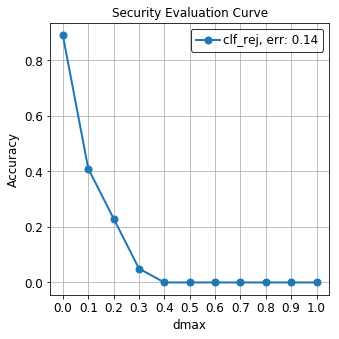

In [42]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
rej_sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
rej_sec_eval.run_sec_eval(attack_ds, double_init=False)

from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    rej_sec_eval.sec_eval_data, marker='o', label='clf_rej', show_average=True)

---

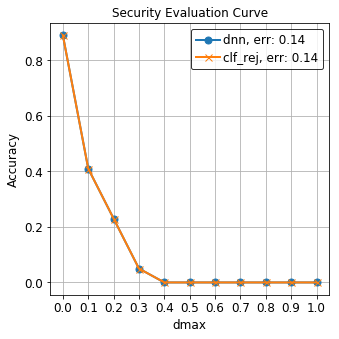

In [43]:
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    dnn_sec_eval.sec_eval_data, marker='o', label='dnn', show_average=True)

fig.sp.plot_sec_eval(
    rej_sec_eval.sec_eval_data, marker='x', label='clf_rej', show_average=True)